# **ALZHEIMER PREDICTION**
In the following project the objective is to predict whether a patient has potential to develop Alzheimer desease based on data that was obtained using MRI (Magnetic Resonance Image) for Young, Middle Aged, Nondemented and Demented Older Adults.

# **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np

# One-hot encoding and standardization 
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Data splitting
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from matplotlib.colors import ListedColormap


# **Loading Datasets**

In [2]:
#Cross-sectional MRI Data in Young, Middle Aged, Nondemented and Demented Older Adults
cross_sectional = pd.read_csv('/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv')
cross_sectional.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [3]:
#Longitudinal MRI Data in Nondemented and Demented Older Adults
longitudinal = pd.read_csv('/kaggle/input/mri-and-alzheimers/oasis_longitudinal.csv')
longitudinal.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


#  **Data Preparation**

**Get rid of the unnecessary columns, renaming columns**

In [4]:
longitudinal = longitudinal.drop(columns=['Subject ID', 'MRI ID', 'Hand', 'Visit', 'SES'])
longitudinal = longitudinal.rename(columns={'M/F' : 'Gender'})
longitudinal.describe()

,MR Delay,Age,EDUC,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,595.104558,77.013405,14.597855,27.342318,0.290885,1488.128686,0.729568,1.195461
std,635.485118,7.640957,2.876339,3.683244,0.374557,176.139286,0.037135,0.138092
min,0.000000,60.000000,6.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,0.000000,71.000000,12.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,552.000000,77.000000,15.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,873.000000,82.000000,16.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,2639.000000,98.000000,23.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [5]:
cross_sectional = cross_sectional.drop(columns=['ID', 'Delay', 'Hand','SES'])
cross_sectional = cross_sectional.rename(columns={'M/F' : 'Gender'})
cross_sectional.describe()

,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF
count,436.000000,235.000000,235.00000,235.000000,436.000000,436.000000,436.000000
mean,51.357798,3.178723,27.06383,0.285106,1481.919725,0.791670,1.198894
std,25.269862,1.311510,3.69687,0.383405,158.740866,0.059937,0.128682
min,18.000000,1.000000,14.00000,0.000000,1123.000000,0.644000,0.881000
25%,23.000000,2.000000,26.00000,0.000000,1367.750000,0.742750,1.111750
50%,54.000000,3.000000,29.00000,0.000000,1475.500000,0.809000,1.190000
75%,74.000000,4.000000,30.00000,0.500000,1579.250000,0.842000,1.284250
max,96.000000,5.000000,30.00000,2.000000,1992.000000,0.893000,1.563000


**Cheking if the two datasets are completely equal so that I know whether I should merge them together**

In [6]:
def check_if_equal(df1, df2):
    if df1.shape != df2.shape:
        return False
    df1_sorted = df1.sort_values(by=df1.columns.tolist()).reset_index(drop=True)
    df2_sorted = df2.sort_values(by=df2.columns.tolist()).reset_index(drop=True)
    return df1_sorted.equals(df2_sorted)

check_if_equal(cross_sectional,longitudinal)

False

**Mergin the datasets (since we do have some distinct columns between them both)**

In [7]:
find_difference_when_merge = pd.merge(cross_sectional, longitudinal, indicator=True, how='outer')
differences = find_difference_when_merge[find_difference_when_merge['_merge'] != 'both']
differences_longitudinal = differences[cross_sectional.columns]
final_data = pd.concat([cross_sectional, differences_longitudinal], ignore_index=True)


final_data.describe()

,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF
count,1233.000000,464.000000,829.000000,831.000000,1233.000000,1233.000000,1233.000000
mean,58.861314,3.183190,27.160434,0.287004,1484.379562,0.773534,1.197479
std,24.572535,1.310721,3.707881,0.379123,164.547664,0.061126,0.131880
min,18.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,29.000000,2.000000,26.000000,0.000000,1365.000000,0.723000,1.110000
50%,69.000000,3.000000,29.000000,0.000000,1475.000000,0.770000,1.190000
75%,78.000000,4.000000,30.000000,0.500000,1583.000000,0.832000,1.289000
max,98.000000,5.000000,30.000000,2.000000,2004.000000,0.893000,1.587000


**Check for NA values in the final data**

In [8]:
final_data.isna().sum()

Gender      0
Age         0
Educ      769
MMSE      404
CDR       402
eTIV        0
nWBV        0
ASF         0
dtype: int64

**Remove the NA values**

In [9]:
final_data = final_data.dropna(subset=['Educ', 'MMSE', 'CDR'])
final_data.isna().sum()

Gender    0
Age       0
Educ      0
MMSE      0
CDR       0
eTIV      0
nWBV      0
ASF       0
dtype: int64

Now that I got rid of the NA values. I can proceed with data analysis and potentially removing outliers if present.

# **Index the data**

In [10]:
final_data['ID'] = final_data.index
final_data

,Gender,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF,ID
0,F,74,2.0,29.0,0.0,1344,0.743,1.306,0
1,F,55,4.0,29.0,0.0,1147,0.810,1.531,1
2,F,73,4.0,27.0,0.5,1454,0.708,1.207,2
8,M,74,5.0,30.0,0.0,1636,0.689,1.073,8
9,F,52,3.0,30.0,0.0,1321,0.827,1.329,9
...,...,...,...,...,...,...,...,...,...
1219,M,88,1.0,26.0,1.0,1419,0.674,1.236,1219
1223,M,89,4.0,28.0,0.0,1631,0.682,1.076,1223
1226,M,90,2.0,21.0,0.5,1307,0.689,1.342,1226
1227,M,90,1.0,23.0,0.5,1668,0.644,1.052,1227


# **Data Analysis**

Box plot

Age        Axes(0.125,0.712609;0.227941x0.167391)
Educ    Axes(0.398529,0.712609;0.227941x0.167391)
MMSE    Axes(0.672059,0.712609;0.227941x0.167391)
CDR        Axes(0.125,0.511739;0.227941x0.167391)
eTIV    Axes(0.398529,0.511739;0.227941x0.167391)
nWBV    Axes(0.672059,0.511739;0.227941x0.167391)
ASF         Axes(0.125,0.31087;0.227941x0.167391)
ID       Axes(0.398529,0.31087;0.227941x0.167391)
dtype: object

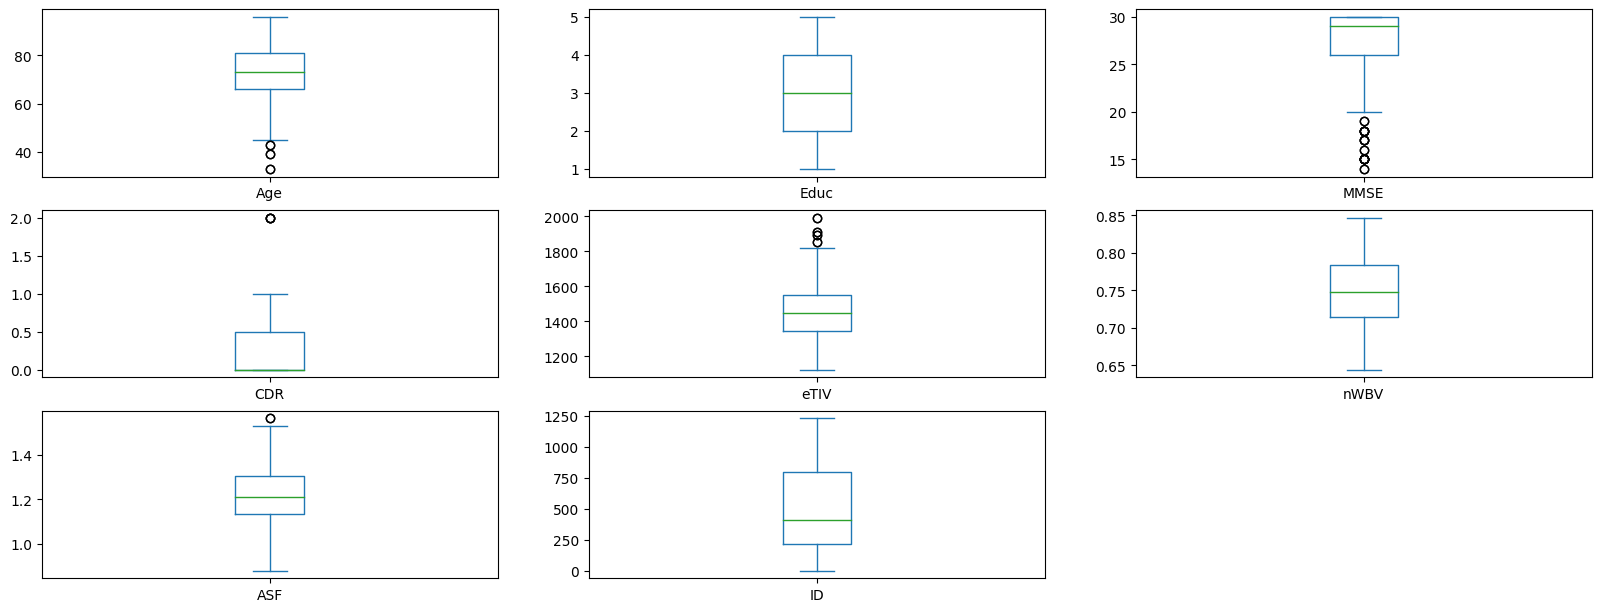

In [11]:
final_data.plot(kind='box', subplots=True, layout=(4,3), sharex=False, figsize=(20, 10))

From the box plot itself we can see that we do have a presence of outliers in fer columns, but let's visualize the data with some more graphs before moving to deal with the outliers.

To check the distribution, I will use Histogram.

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Educ'}>,
        <Axes: title={'center': 'MMSE'}>],
       [<Axes: title={'center': 'CDR'}>,
        <Axes: title={'center': 'eTIV'}>,
        <Axes: title={'center': 'nWBV'}>],
       [<Axes: title={'center': 'ASF'}>, <Axes: title={'center': 'ID'}>,
        <Axes: >]], dtype=object)

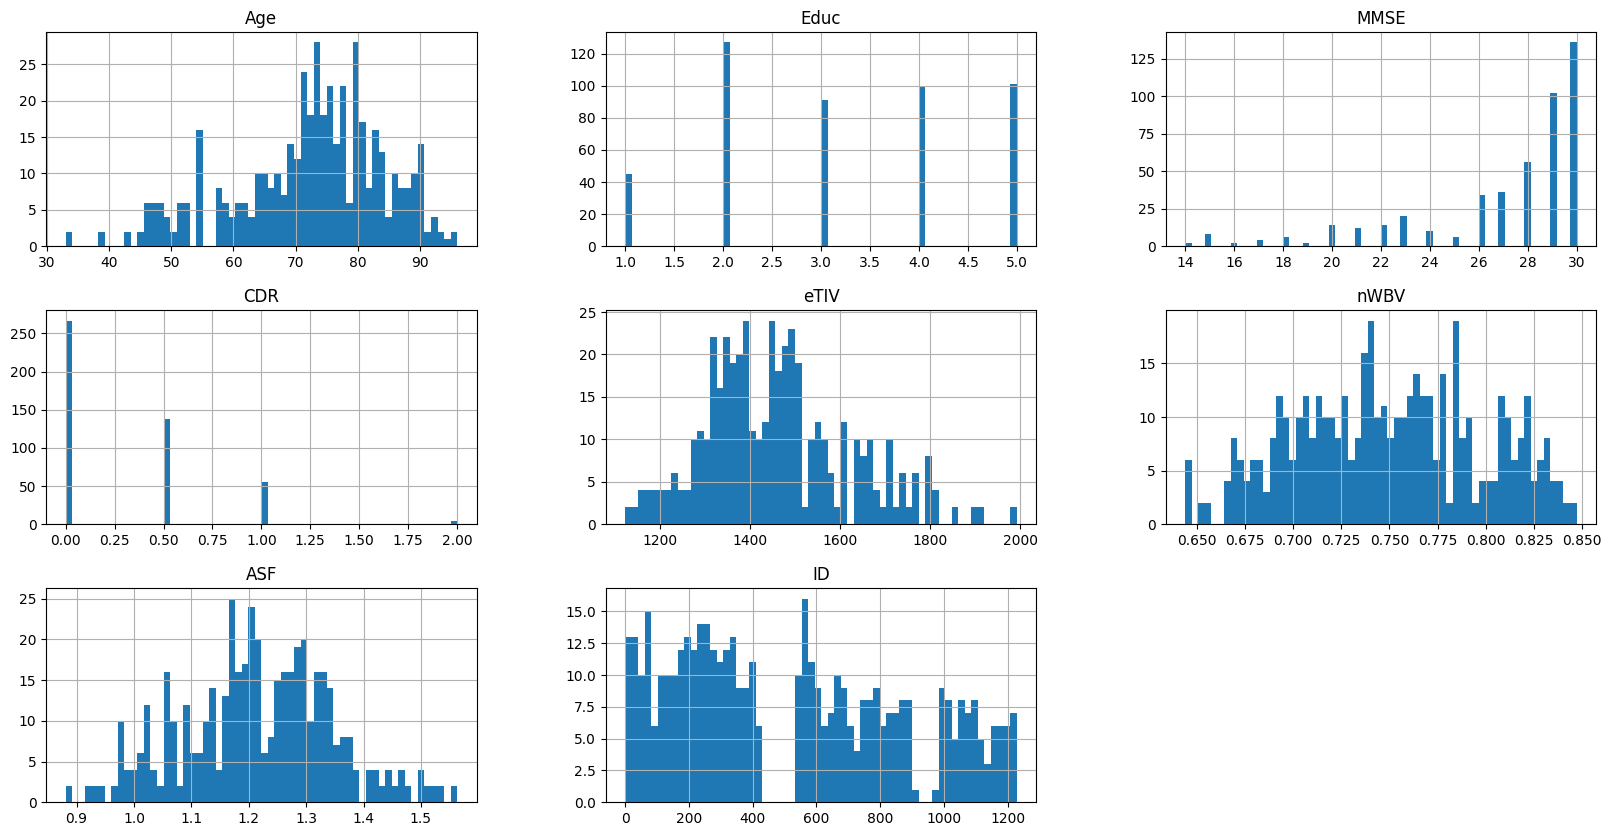

In [12]:
final_data.hist(bins=60, figsize=(20, 10))

The skewness for some of the histograms (on the x axis) indicates that there's presence of at least one (or more) rows from our data that have that values. From this we can try and understand that this might represent a potential outlier indicator.

From both the Histogram and the Box plot we can see that we have potential outliers in the columns (Age, CDR, eTIV, MMSE, ASF). Therefore, I will try to refine the data by removing the potential outliers. I will start with "Age" column. As we can see for the age < 50 we start to have a lot less samples compared to > 50 (It's maybe even better to consider it as < 60, but let's see where we get with this first, and then I will refine further if needed). Let's determine which samples have age < 50. And I will further use scatter plots to really make it easier and spot the stand outs from our data

In [13]:
final_data[final_data['Age']<50]

,Gender,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF,ID
16,M,39,3.0,28.0,0.0,1636,0.813,1.073,16
18,F,48,5.0,29.0,0.0,1326,0.785,1.323,18
40,F,47,4.0,30.0,0.0,1346,0.829,1.304,40
53,F,46,5.0,30.0,0.0,1585,0.817,1.107,53
64,M,33,4.0,30.0,0.0,1709,0.784,1.027,64
66,F,49,5.0,30.0,0.0,1459,0.808,1.203,66
69,M,43,4.0,30.0,0.0,1547,0.847,1.134,69
81,F,47,4.0,30.0,0.0,1311,0.835,1.339,81
89,F,47,5.0,29.0,0.0,1357,0.809,1.294,89
166,F,49,4.0,30.0,0.0,1316,0.820,1.334,166


<Axes: xlabel='ID', ylabel='Age'>

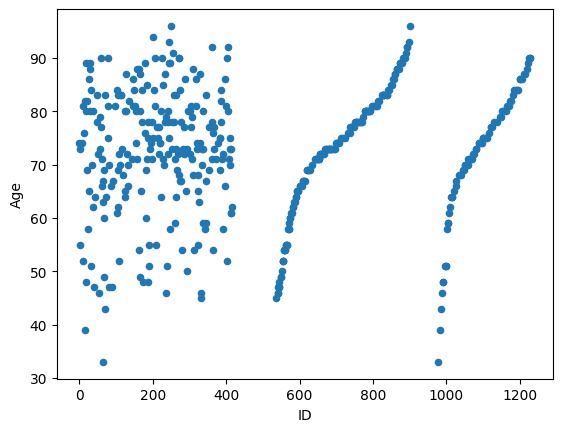

In [14]:
final_data[['ID','Age']].plot(kind='scatter', x='ID', y='Age')

I will remove all the data which is < 50, due to the obvious potential for outliers for samples that have age < 50 (Even though the scatter is not really clear, but let's keep it for now and I will adjust later).

In [15]:
final_data = final_data[final_data['Age']<=50.00]

I will proceed with MMSE column, based on the Histogram I will check which samples fall under the separation of < 26.

In [16]:
final_data[final_data['MMSE']>26]

,Gender,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF,ID
16,M,39,3.0,28.0,0.0,1636,0.813,1.073,16
18,F,48,5.0,29.0,0.0,1326,0.785,1.323,18
40,F,47,4.0,30.0,0.0,1346,0.829,1.304,40
53,F,46,5.0,30.0,0.0,1585,0.817,1.107,53
64,M,33,4.0,30.0,0.0,1709,0.784,1.027,64
66,F,49,5.0,30.0,0.0,1459,0.808,1.203,66
69,M,43,4.0,30.0,0.0,1547,0.847,1.134,69
81,F,47,4.0,30.0,0.0,1311,0.835,1.339,81
89,F,47,5.0,29.0,0.0,1357,0.809,1.294,89
166,F,49,4.0,30.0,0.0,1316,0.820,1.334,166


<Axes: xlabel='ID', ylabel='MMSE'>

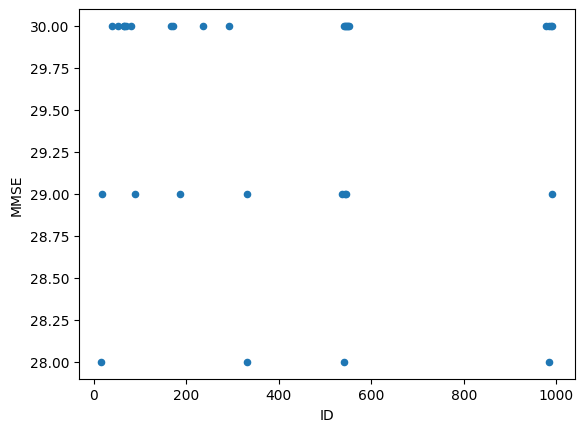

In [17]:
final_data[['ID','MMSE']].plot(kind='scatter', x='ID', y='MMSE')

Then with CDR, for the samples > 1.

In [18]:
final_data[final_data['CDR']> 1]

,Gender,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF,ID
